<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Introduction to image similarity

Image similarity methods can be used to build Image Retrieval systems where, given a query image, the goal is to find all similar images in a reference set. These systems can be used e.g. on a shopping website to suggest related products.

In this tutorial we build an image retrieval system based on leveraging DNNs trained for image classification. Representing images as the output of a DNN is a powerful approach and shown to give good results on a wide variety of tasks. Given a query image, we find the most similar images in the reference set by computing the pairwise distances as illustrated below, and by returning the images with the lowest distance to the query image.

The distance between two images is computed by:
<img src="media/image_similarity_diagram2.jpg" width="600px" />

- Representing each image using the output of a DNN which was pre-trained on millions of images and fine-tuned on images from the same domain. The input to the DNN is an image, and the output is the penultimate layer which, for the ResNet-18 model used in this tutorial, consists of 512-floating point values. Note that we use only a single DNN which takes each of the two images independently as input.
- Normalizing each of the 512-floats DNN image representations (aka. embeddings or features) to be unit vectors, i.e. have an L2 norm of one.
- Finally, obtaining the distance between the two input images by computing the L2 distance between their respective DNN representations.

This notebook starts by loading a dataset and splitting it into a training and a validation set. The training set is used to refine an ImageNet pre-trained ResNet-18 DNN, which is then used to compute the DNN features for each image. The validation set is used in an image retrieval example where, given a query image, the top similar images are displayed. This is followed by a quantitative evaluation of the proposed image similarity system.

## Initialization

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Regular python libraries
import sys
import numpy as np
from pathlib import Path
import random

import scrapbook as sb

# fast.ai
import fastai
# from fastai.vision import (
#     accuracy,
#     cnn_learner,
#     DatasetType,
#     ImageList,
#     imagenet_stats,
#     models,
#     partial,
#     get_transforms,
#     flip_lr
# )

from fastai.vision import *
from fastai.callbacks.hooks import * 

# Computer Vision repository
sys.path.extend([".", "../.."])  # to access the utils_cv library
from utils_cv.classification.data import Urls
from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor, db_num_workers
from utils_cv.similarity.data import comparative_set_builder
from utils_cv.similarity.metrics import (
    compute_distances,
    positive_image_ranks,
    recall_at_k,
)
from utils_cv.similarity.model import compute_features, compute_features_learner
from utils_cv.similarity.plot import (
    plot_comparative_set,
    plot_distances,
    plot_ranks_distribution,
    plot_recalls,
)
from utils_cv.similarity.widget import RetrievalWidget

In [3]:
print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.57
Torch is using GPU: Tesla K80


In [4]:
import torch; print(torch.__version__)

1.2.0


## Data preparation
We start with parameter specifications and data preparation. We use the *Fridge objects* dataset, which is composed of 134 images, divided into 4 classes: can, carton, milk bottle and water bottle. To train your own image retrieval systems, simply change the `DATA_PATH` variable below to point to a different (single-label) dataset.

In [5]:
# Set dataset, model and evaluation parameters
# DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
DATA_PATH = unzip_url('../../data/limmert_data_2.zip', exist_ok=True)

# DNN configuration and learning parameters
EPOCHS_HEAD = 4
EPOCHS_BODY = 12
LEARNING_RATE = 10* 1e-4
BATCH_SIZE = 16
ARCHITECTURE = models.resnet34
IM_SIZE = 270
IM_SIZE_HALF = IM_SIZE // 2

In [6]:
help(get_transforms)

Help on function get_transforms in module fastai.vision.transform:

get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]
    Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms.



In [7]:
tfms = get_transforms(max_rotate= 10.,max_zoom=1., max_lighting=0.20, do_flip=False,
                      max_warp=0., xtra_tfms=[flip_lr(), brightness(change=(0.3, 0.60), p=0.7), contrast(scale=(0.5, 2), p=0.7),
                                              crop_pad(size=600, padding_mode='border', row_pct=0.,col_pct=0.),
                                              rand_zoom(scale=(1.,1.5)), rand_crop(),
                                              perspective_warp(magnitude=(-0.1,0.1)),
                                              symmetric_warp(magnitude=(-0.1,0.1)) ])

We can now build our training data object, and split it to get a certain percentage (here 20%) assigned to a validation set.

In [8]:
src = (ImageList.from_folder(DATA_PATH)
        .split_by_rand_pct(0.2, seed=20)
        .label_from_folder())

In [9]:
data = (src.transform(tfms, resize_method=ResizeMethod.SQUISH, padding_mode='reflection', size=IM_SIZE_HALF)
        .databunch(bs=BATCH_SIZE, num_workers=db_num_workers())
        .normalize(imagenet_stats))

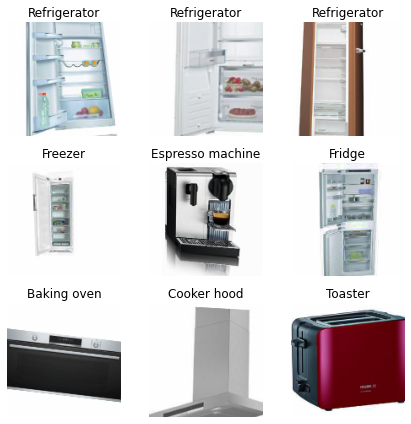

In [10]:
data.show_batch(rows=3, figsize=(6, 6))

In [11]:
print(f'Classes: \n {data.classes}')

Classes: 
 ['Baking oven', 'Blood pressure measuring instrument', 'Coffee maker', 'Cooker hood', 'Cooking pot', 'Dishwasher', 'Espresso machine', 'Freezer', 'Fridge', 'Grill', 'Hair dryer', 'Hob', 'Ironing device', 'Kitchen machine', 'Microwave oven', 'Refrigerator', 'Slicing machine', 'Toaster']


In [12]:
print(f"""\
Training set: {len(data.train_ds.x)} images
Validation set: {len(data.valid_ds.x)} images\
"""
)

Training set: 1299 images
Validation set: 324 images


In [13]:
# Load images into fast.ai's ImageDataBunch object
# random.seed(642)
# data = (
#     ImageList.from_folder(DATA_PATH)
#     .split_by_rand_pct(valid_pct=0.2, seed=20)
#     .label_from_folder()
#     .transform(size=IM_SIZE)
#     .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
#     .normalize(imagenet_stats)
# )

# print(f"""\
# Training set: {len(data.train_ds.x)} images
# Validation set: {len(data.valid_ds.x)} images\
# """
# )

# # Display example images
# data.show_batch(rows=3, figsize=(6, 6))

## Classification model fine-tuning

We begin by retrieving a [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) CNN from fast.ai's library which is pre-trained on ImageNet, and fine-tune the model on our training set. We use the same training parameters and take the same approach as what we did in our [classification notebooks](https://github.com/microsoft/ComputerVision/tree/master/classification/notebooks), training first the (new) last layer only, and then the full DNN.

Note how we train the DNN here on an image classification task but will use it as featurizer later for image similarity.

In [14]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
#     callback_fns=[partial(TrainMetricsRecorder, show_graph=True)],
    ps=0 #Leave dropout at zero. Higher values tend to perform significantly worse
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 97.9MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-03
Min loss divided by 10: 3.31E-03


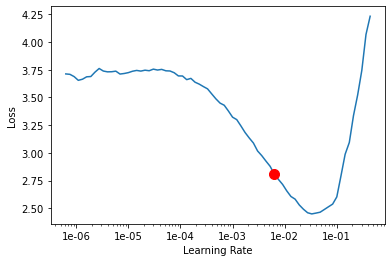

In [15]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [16]:
lr=3e-2
# learn.fit_one_cycle(2, max_lr=slice(1e-2), wd = (1e-6, 1e-4, 1e-2), pct_start=0.5)

In [17]:
# Train the last layer using a larger rate since most of the DNN is fixed.
learn.fit_one_cycle(EPOCHS_HEAD, lr)

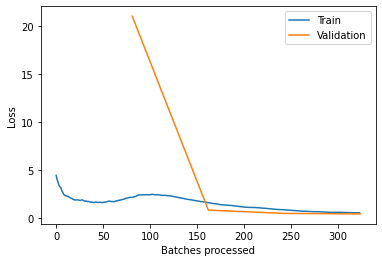

In [18]:
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-07


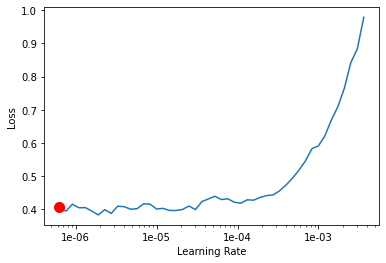

In [19]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

Let's now unfreeze all the layers and fine-tuning the model more 

In [20]:
learn.fit_one_cycle(EPOCHS_BODY, slice(3e-06, lr/5))

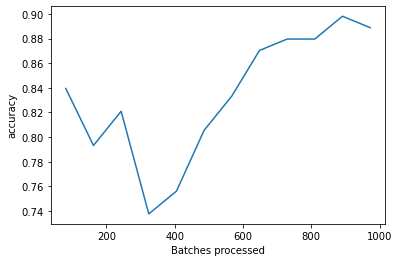

In [21]:
learn.recorder.plot_metrics()

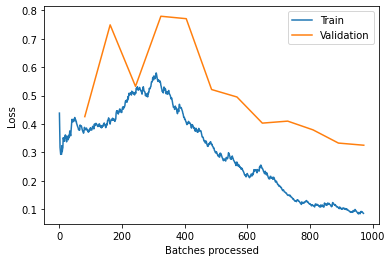

In [22]:
learn.recorder.plot_losses()

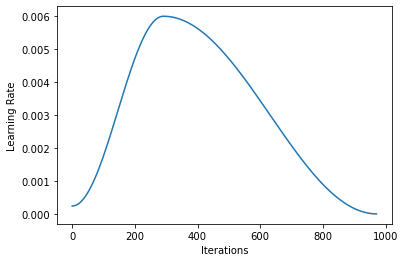

In [23]:
learn.recorder.plot_lr()

In [24]:
data_big = (src.transform(tfms, resize_method=ResizeMethod.SQUISH, padding_mode='reflection', size=IM_SIZE)
        .databunch(bs=BATCH_SIZE, num_workers=db_num_workers())
        .normalize(imagenet_stats))

learn.data = data_big

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-05


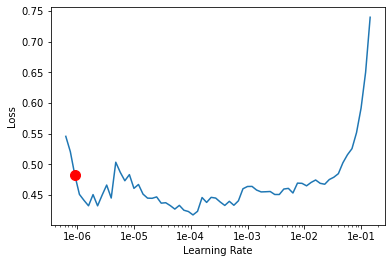

In [25]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [26]:
lr = 1e-5
learn.fit_one_cycle(EPOCHS_HEAD, lr)

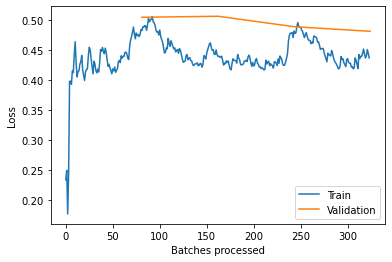

In [27]:
learn.recorder.plot_losses()

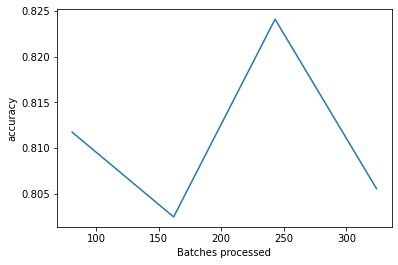

In [28]:
learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 6.31E-08


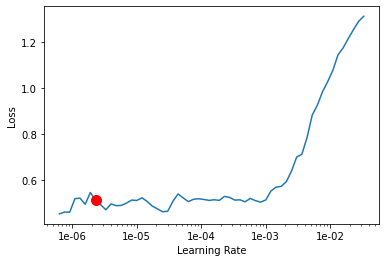

In [29]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [30]:
learn.fit_one_cycle(EPOCHS_BODY, slice(7e-05, lr/5))

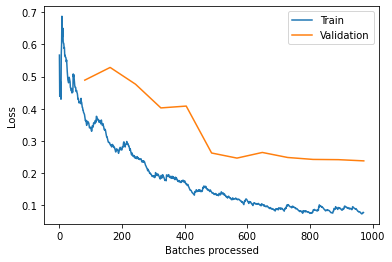

In [31]:
learn.recorder.plot_losses()

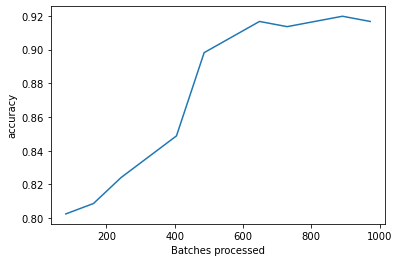

In [32]:
learn.recorder.plot_metrics()

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data_big.valid_ds)==len(losses)==len(idxs)

True

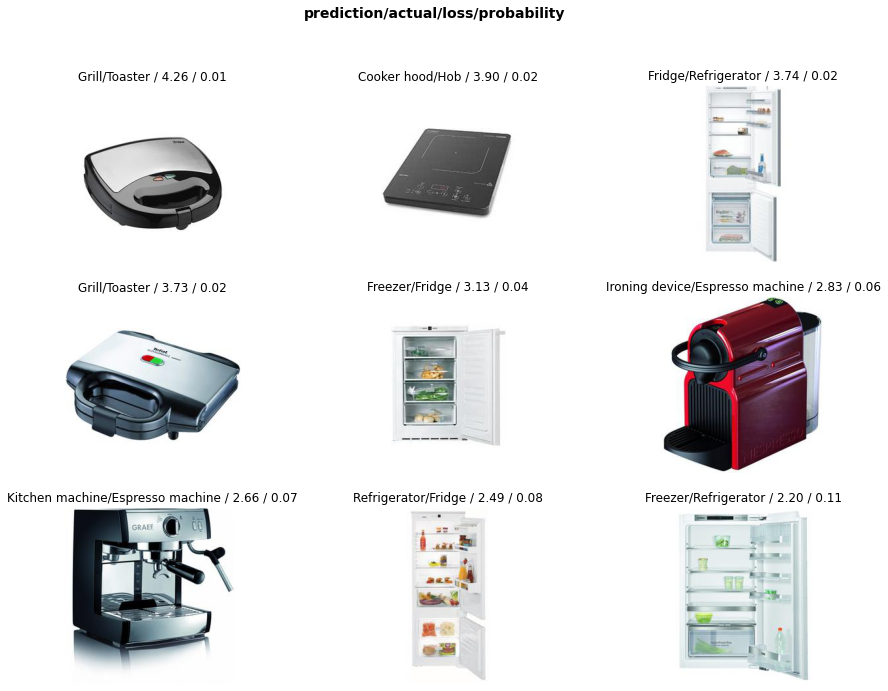

In [34]:
interp.plot_top_losses(9, figsize=(15,11))

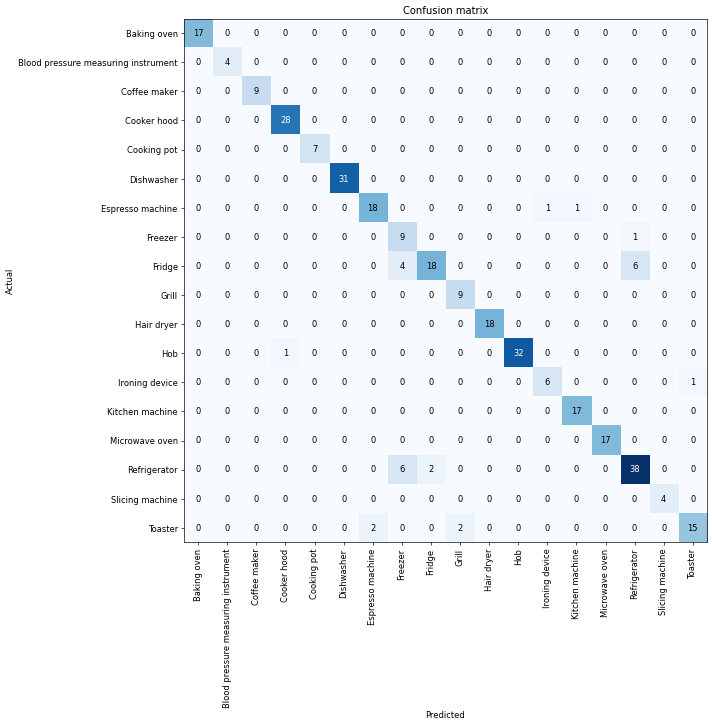

In [35]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [36]:
interp.most_confused(min_val=2)

[('Fridge', 'Refrigerator', 6),
 ('Refrigerator', 'Freezer', 6),
 ('Fridge', 'Freezer', 4),
 ('Refrigerator', 'Fridge', 2),
 ('Toaster', 'Espresso machine', 2),
 ('Toaster', 'Grill', 2)]

In [37]:
learn.save('final_model_resnet34_annoy_limmert_data_2')

In [38]:
learn.export('final_model_resnet34_annoy_limmert_data_2')

In [39]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

## Fastai Hooks

In [40]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [41]:
learn.model[1][-2] 

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [42]:
sf = SaveFeatures(learn.model[1][4])

In [43]:
_= learn.get_preds(data_big.train_ds)
_= learn.get_preds(DatasetType.Valid)

In [44]:
len(sf.features)

1623

In [45]:
img_path = [str(x) for x in (list(data_big.train_ds.items) +list(data_big.valid_ds.items))]
label = [data_big.classes[x] for x in (list(data_big.train_ds.y.items) +list(data_big.valid_ds.y.items))]
label_id = [x for x in (list(data_big.train_ds.y.items) +list(data_big.valid_ds.y.items))]

In [46]:
len(img_path), len(label), len(label_id)

(1623, 1623, 1623)

In [47]:
df_new = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
# df_new.loc[500:600]
df_new

img_path           label  \
0     /home/ec2-user/SageMaker/visual-search-thesis/...    Refrigerator   
1     /home/ec2-user/SageMaker/visual-search-thesis/...    Refrigerator   
2     /home/ec2-user/SageMaker/visual-search-thesis/...    Refrigerator   
3     /home/ec2-user/SageMaker/visual-search-thesis/...    Refrigerator   
4     /home/ec2-user/SageMaker/visual-search-thesis/...    Refrigerator   
...                                                 ...             ...   
1618  /home/ec2-user/SageMaker/visual-search-thesis/...     Baking oven   
1619  /home/ec2-user/SageMaker/visual-search-thesis/...      Dishwasher   
1620  /home/ec2-user/SageMaker/visual-search-thesis/...     Cooker hood   
1621  /home/ec2-user/SageMaker/visual-search-thesis/...      Dishwasher   
1622  /home/ec2-user/SageMaker/visual-search-thesis/...  Microwave oven   

      label_id  
0           15  
1           15  
2           15  
3           15  
4           15  
...        ...  
1618         0  
1619         5  
1620         3  
1621         5  
1622        14  

[1623 rows x 3 columns]

In [48]:
array = np.array(sf.features)

In [49]:
x=array.tolist()

In [50]:
df_new['img_repr'] = x

In [51]:
df_new.head()

img_path         label  label_id  \
0  /home/ec2-user/SageMaker/visual-search-thesis/...  Refrigerator        15   
1  /home/ec2-user/SageMaker/visual-search-thesis/...  Refrigerator        15   
2  /home/ec2-user/SageMaker/visual-search-thesis/...  Refrigerator        15   
3  /home/ec2-user/SageMaker/visual-search-thesis/...  Refrigerator        15   
4  /home/ec2-user/SageMaker/visual-search-thesis/...  Refrigerator        15   

                                            img_repr  
0  [12.014185905456543, 0.0, 0.0, 0.0, 14.7549705...  
1  [5.163901329040527, 0.0, 0.0, 12.5484571456909...  
2  [26.917144775390625, 0.0, 4.213227272033691, 0...  
3  [15.829734802246094, 0.2749384343624115, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 13.109044075012207, 8.913...

In [52]:
df_new.shape

(1623, 4)

## Image similarity using Cosine Similarity

In [53]:
from scipy.spatial.distance import cosine
import time

def get_similar_images(img_index, n=10):
    start = time.time()
    base_img_id, base_vector, base_label  = df_new.iloc[img_index, [0, 3, 1]]
    cosine_similarity = 1 - df_new['img_repr'].apply(lambda x: cosine(x, base_vector))
    similar_img_ids = np.argsort(cosine_similarity)[-11:-1][::-1]
    end = time.time()
    print(f'{end - start} secs')
    return base_img_id, base_label, df_new.iloc[similar_img_ids]

In [199]:
# Test 410, 411, 521, 650, 659, 759??, 765, 1170, 1270, 1370
base_image, base_label, similar_images_df = get_similar_images(1470) # 890

0.16838431358337402 secs


Fridge
/home/ec2-user/SageMaker/visual-search-thesis/visual-search/data/limmert_data_2/Fridge/198.jpg


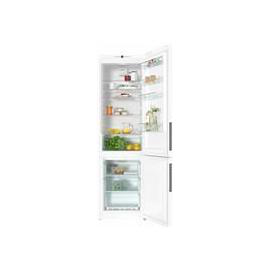

In [200]:
print(base_label)
print(base_image)
open_image(base_image)

In [201]:
similar_images_df

img_path   label  label_id  \
321   /home/ec2-user/SageMaker/visual-search-thesis/...  Fridge         8   
294   /home/ec2-user/SageMaker/visual-search-thesis/...  Fridge         8   
313   /home/ec2-user/SageMaker/visual-search-thesis/...  Fridge         8   
300   /home/ec2-user/SageMaker/visual-search-thesis/...  Fridge         8   
362   /home/ec2-user/SageMaker/visual-search-thesis/...  Fridge         8   
1371  /home/ec2-user/SageMaker/visual-search-thesis/...  Fridge         8   
305   /home/ec2-user/SageMaker/visual-search-thesis/...  Fridge         8   
341   /home/ec2-user/SageMaker/visual-search-thesis/...  Fridge         8   
273   /home/ec2-user/SageMaker/visual-search-thesis/...  Fridge         8   
353   /home/ec2-user/SageMaker/visual-search-thesis/...  Fridge         8   

                                               img_repr       tsne1  \
321   [13.78670597076416, 13.757423400878906, 0.0, 0... -142.840195   
294   [15.49741268157959, 2.663459062576294, 0.0, 0.... -132.242111   
313   [24.515600204467773, 0.1630759835243225, 0.0, ... -136.929077   
300   [21.602344512939453, 8.545711517333984, 0.0, 0... -170.967728   
362   [21.274032592773438, 0.0, 0.0, 0.0, 16.4349403... -135.734299   
1371  [25.77535629272461, 13.5133695602417, 0.0, 0.0... -155.693771   
305   [15.801300048828125, 8.973470687866211, 0.0, 0... -123.428436   
341   [16.13882827758789, 0.0, 0.0, 0.0, 19.07366752... -136.962067   
273   [11.875143051147461, 3.987806797027588, 0.0, 0... -113.059151   
353   [20.740516662597656, 13.995020866394043, 0.0, ... -176.120300   

          tsne2      tsne3  
321  -17.867109 -47.342125  
294  -12.059916 -43.579765  
313  -19.733288 -33.607178  
300   19.300257 -67.297295  
362  -26.791506 -29.051834  
1371  -7.241223 -51.600914  
305  -12.862954 -46.234497  
341   -7.732243 -31.901882  
273  -32.072594 -42.207577  
353   15.957415 -59.669041

In [202]:
def show_similar_images(similar_images_df):
    images = [open_image(img_id) for img_id in similar_images_df['img_path']]
    categories = [learn.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learn.data.show_xys(images, categories)

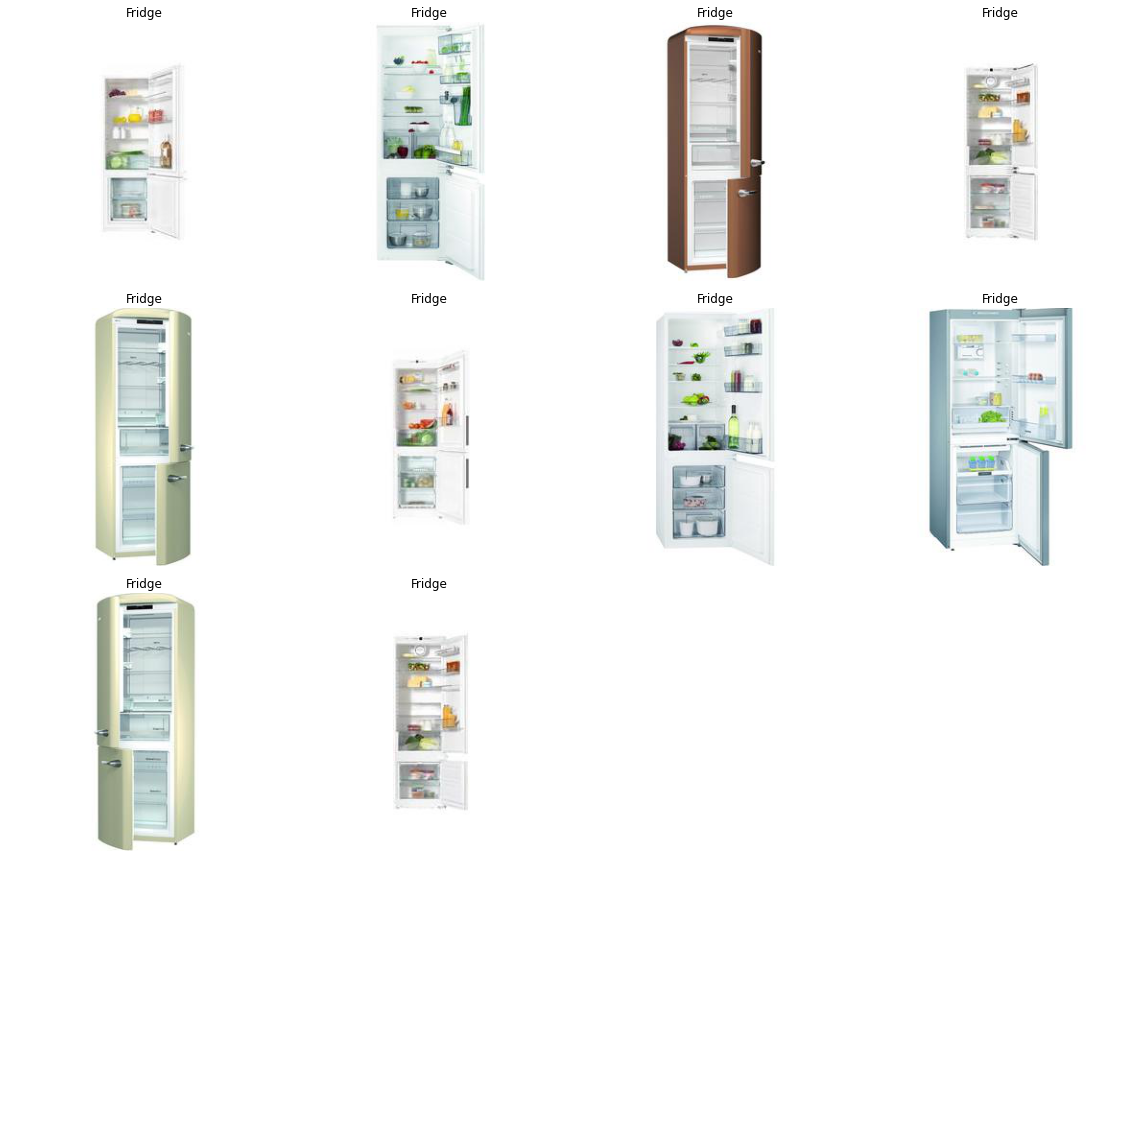

In [203]:
show_similar_images(similar_images_df)

## T-SNE

In [59]:
from sklearn.manifold import TSNE

img_repr_matrix = [list(x) for x in df_new['img_repr'].values]
tsne = TSNE(n_components=3, verbose=10, init='pca', perplexity=30, n_iter=500, n_iter_without_progress=100)
tsne_results_3 = tsne.fit_transform(img_repr_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1623 samples in 0.060s...
[t-SNE] Computed neighbors for 1623 samples in 2.164s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1623
[t-SNE] Computed conditional probabilities for sample 1623 / 1623
[t-SNE] Mean sigma: 33.617479
[t-SNE] Computed conditional probabilities in 0.147s
[t-SNE] Iteration 50: error = 88.8451920, gradient norm = 0.0281084 (50 iterations in 1.970s)
[t-SNE] Iteration 100: error = 88.9279327, gradient norm = 0.0304632 (50 iterations in 1.638s)
[t-SNE] Iteration 150: error = 87.4773865, gradient norm = 0.0340934 (50 iterations in 1.501s)
[t-SNE] Iteration 200: error = 85.4111481, gradient norm = 0.0294678 (50 iterations in 1.395s)
[t-SNE] Iteration 250: error = 83.8315125, gradient norm = 0.0300882 (50 iterations in 1.329s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.831512
[t-SNE] Iteration 300: error = 1.5806477, gradient norm = 0.0004210 (50 iterations in 1.472s

In [60]:
df_new['tsne1'] = tsne_results_3[:,0]
df_new['tsne2'] = tsne_results_3[:,1]
df_new['tsne3'] = tsne_results_3[:,2]

In [61]:
df_new.to_parquet('similar_images')

In [62]:
pip install plotly_express

     |████████████████████████████████| 231 kB 13.4 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 19.9 MB/s eta 0:00:01
     |████████████████████████████████| 13.1 MB 50.9 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=bd134b6d2e72790ba4d5d5afaa706e9ae91b2dacb961c4299757a075a77d5480
  Stored in directory: /home/ec2-user/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [63]:
import plotly_express as px
px.scatter_3d(df_new, x='tsne1', y='tsne2', z='tsne3', color='label')